##  Building a "Recommender System" to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from surprise import Reader, Dataset, SVD, evaluate

ModuleNotFoundError: No module named 'surprise'

### USERS FILE DESCRIPTION

=========================================================================

User information is in the file "users.dat" and is in the following format:

UserID::Gender::Age::Occupation::Zip-code


### MOVIES FILE DESCRIPTION

=========================================================================

Movie information is in the file "movies.dat" and is in the following format:

MovieID::Title::Genres


### RATINGS FILE DESCRIPTION

=========================================================================

Rating information is in the file "ratings.dat" and is in the following format:

UserID::MovieID::Rating::Timestamp

In [20]:
df_users = pd.read_csv('zee-users.dat', delimiter='::', encoding='latin-1')
df_movies = pd.read_csv('zee-movies.dat', delimiter='::', encoding='latin-1')
df_ratings = pd.read_csv('zee-ratings.dat', delimiter='::', encoding='latin-1')

In [21]:
df_movies.rename(columns={'Movie ID':'MovieID'},inplace=True)  # replacing MovieID to keep it consistent across

In [10]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
df_users.shape

(6040, 5)

In [14]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [22]:
age_categories = {1: "Under 18",18: "18-24",25: "25-34",35: "35-44",45: "45-49",50: "50-55",56: "56+"}
occupation_categories = {0: "other",1: "academic/educator",2: "artist",3: "clerical/admin",4: "college/grad student",5: "customer service",6: "doctor/health care",7: "executive/managerial",8: "farmer",9: "homemaker",10: "K-12 student",11: "lawyer",12: "programmer",13: "retired",14: "sales/marketing",15: "scientist",16: "self-employed",17: "technician/engineer",18: "tradesman/craftsman",19: "unemployed",20: "writer"}

In [24]:
df_users['Age Categories'] = df_users['Age'].replace(age_categories)
df_users['Occupation Category'] = df_users['Occupation'].replace(occupation_categories)

In [25]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code,Age Categories,Occupation Category
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [11]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [51]:
df_movies.shape

(3883, 21)

In [52]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MovieID        3883 non-null   int64 
 1   Title          3883 non-null   object
 2   Genres         3883 non-null   object
 3   Thriller_G     3883 non-null   int64 
 4   War_G          3883 non-null   int64 
 5   Crime_G        3883 non-null   int64 
 6   Western_G      3883 non-null   int64 
 7   Mystery_G      3883 non-null   int64 
 8   Comedy_G       3883 non-null   int64 
 9   Fantasy_G      3883 non-null   int64 
 10  Film-Noir_G    3883 non-null   int64 
 11  Sci-Fi_G       3883 non-null   int64 
 12  Musical_G      3883 non-null   int64 
 13  Horror_G       3883 non-null   int64 
 14  Adventure_G    3883 non-null   int64 
 15  Romance_G      3883 non-null   int64 
 16  Animation_G    3883 non-null   int64 
 17  Action_G       3883 non-null   int64 
 18  Documentary_G  3883 non-null

In [31]:
genres_list = list(set([l2 for l1 in df_movies.Genres.str.split('|').to_list() for l2 in l1]))

In [35]:
genres_list

['Thriller',
 'War',
 'Crime',
 'Western',
 'Mystery',
 'Comedy',
 'Fantasy',
 'Film-Noir',
 'Sci-Fi',
 'Musical',
 'Horror',
 'Adventure',
 'Romance',
 'Animation',
 'Action',
 'Documentary',
 "Children's",
 'Drama']

In [43]:
def genre_flag(x):
    x = x['Genres']
    x_list = x.split('|')
    return [1 if genre in x_list else 0 for genre in genres_list]

In [47]:
temp_df = df_movies.apply(genre_flag,axis=1,result_type='expand')

In [49]:
for i,genre in enumerate(genres_list):
    df_movies[genre+'_G']=temp_df[i]

In [137]:
df_movies['Release year'] = df_movies['Title'].str[-5:-1].apply(int)

In [50]:
df_movies.head()

,MovieID,Title,Genres,Thriller_G,War_G,Crime_G,Western_G,Mystery_G,Comedy_G,Fantasy_G,...,Sci-Fi_G,Musical_G,Horror_G,Adventure_G,Romance_G,Animation_G,Action_G,Documentary_G,Children's_G,Drama_G
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [53]:
df_ratings.shape

(1000209, 4)

In [55]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [64]:
df_ratings['datetime'] = pd.to_datetime(df_ratings.Timestamp,unit='s')

In [70]:
df_ratings['year'] = df_ratings['datetime'].dt.year
df_ratings['hour'] = df_ratings['datetime'].dt.hour
df_ratings['Day of Week'] = df_ratings['datetime'].dt.day_name()

In [78]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp,datetime,year,hour,Day of Week
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,22,Sunday
1,1,661,3,978302109,2000-12-31 22:35:09,2000,22,Sunday
2,1,914,3,978301968,2000-12-31 22:32:48,2000,22,Sunday
3,1,3408,4,978300275,2000-12-31 22:04:35,2000,22,Sunday
4,1,2355,5,978824291,2001-01-06 23:38:11,2001,23,Saturday


### Data Analysis and Visualization

In [79]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code,Age Categories,Occupation Category
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


<AxesSubplot:xlabel='Gender', ylabel='count'>

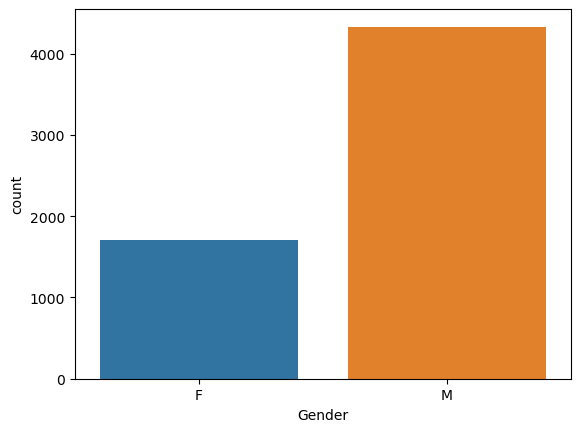

In [80]:
sns.countplot(data=df_users,x='Gender')

<AxesSubplot:xlabel='Age Categories', ylabel='count'>

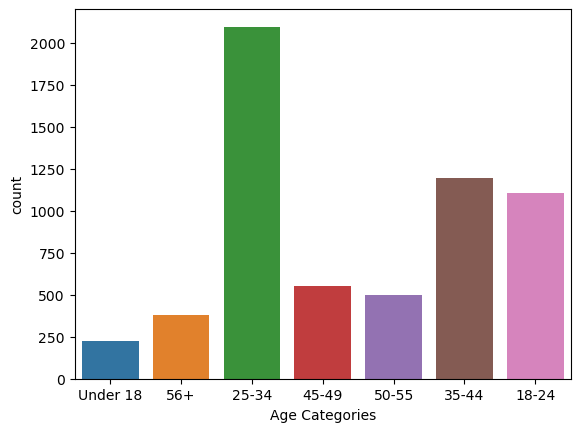

In [81]:
sns.countplot(data=df_users,x='Age Categories')

<AxesSubplot:xlabel='count', ylabel='Occupation Category'>

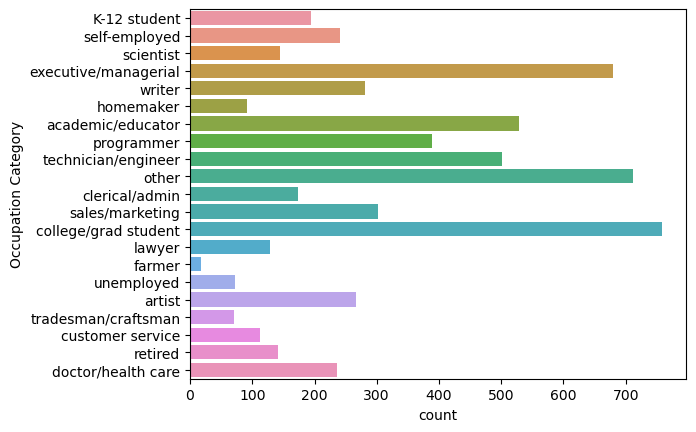

In [83]:
sns.countplot(data=df_users,y='Occupation Category')

In [87]:
df_movies.head()

,MovieID,Title,Genres,Thriller_G,War_G,Crime_G,Western_G,Mystery_G,Comedy_G,Fantasy_G,...,Sci-Fi_G,Musical_G,Horror_G,Adventure_G,Romance_G,Animation_G,Action_G,Documentary_G,Children's_G,Drama_G
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


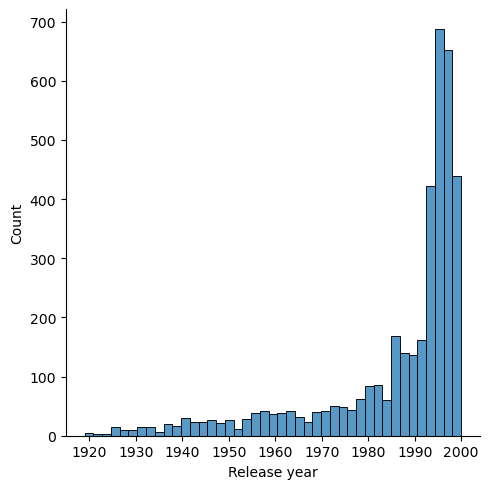

In [139]:
sns.displot(data=df_movies,x='Release year')

In [110]:
df_movies_genre = df_movies.melt(id_vars='Title',
    value_vars=[col for col in df_movies.columns if '_G' in col],
    var_name='Genre',
    value_name='Genre flag',)

In [111]:
df_movies_genre = df_movies_genre[df_movies_genre['Genre flag']==1].reset_index()

In [112]:
df_movies_genre = df_movies_genre.groupby(['Genre'])['Genre flag'].count().sort_values(ascending=False).reset_index()

<AxesSubplot:xlabel='Genre flag', ylabel='Genre'>

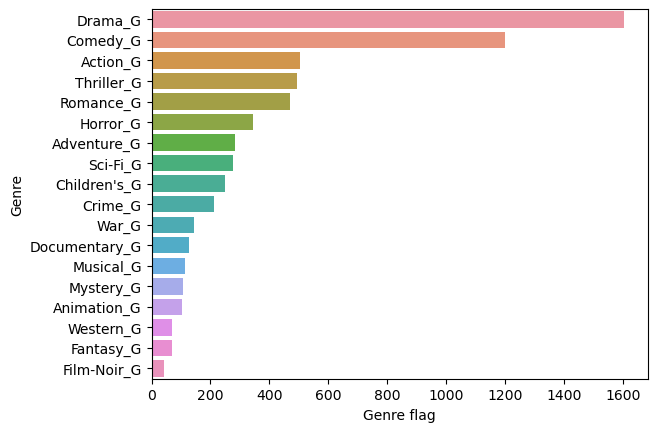

In [113]:
sns.barplot(data=df_movies_genre,y='Genre',x='Genre flag')

In [115]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp,datetime,year,hour,Day of Week
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,22,Sunday
1,1,661,3,978302109,2000-12-31 22:35:09,2000,22,Sunday
2,1,914,3,978301968,2000-12-31 22:32:48,2000,22,Sunday
3,1,3408,4,978300275,2000-12-31 22:04:35,2000,22,Sunday
4,1,2355,5,978824291,2001-01-06 23:38:11,2001,23,Saturday


<AxesSubplot:xlabel='Rating'>

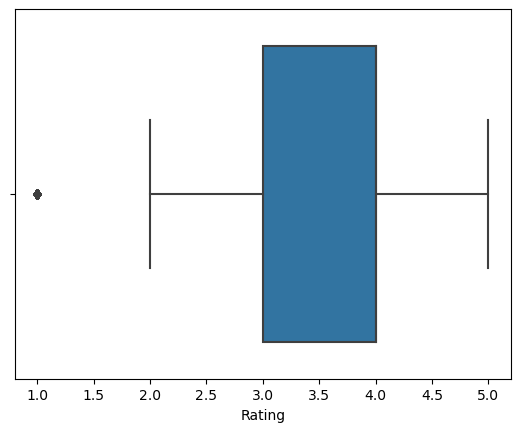

In [116]:
sns.boxplot(df_ratings['Rating'])

<AxesSubplot:xlabel='hour'>

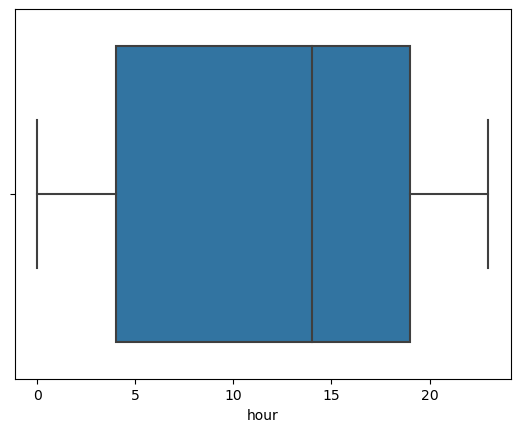

In [117]:
sns.boxplot(df_ratings['hour'])

<AxesSubplot:xlabel='hour', ylabel='count'>

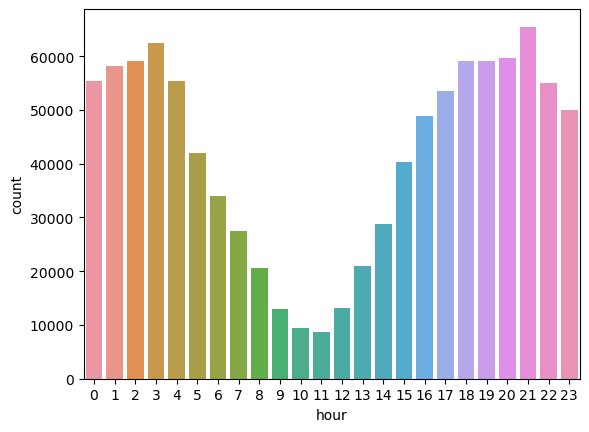

In [119]:
sns.countplot(data = df_ratings, x='hour')

In [120]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code,Age Categories,Occupation Category
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [123]:
df_ratings = df_ratings.merge(df_users[['UserID','Age Categories']],on='UserID')

In [125]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp,datetime,year,hour,Day of Week,Age Categories
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,22,Sunday,Under 18
1,1,661,3,978302109,2000-12-31 22:35:09,2000,22,Sunday,Under 18
2,1,914,3,978301968,2000-12-31 22:32:48,2000,22,Sunday,Under 18
3,1,3408,4,978300275,2000-12-31 22:04:35,2000,22,Sunday,Under 18
4,1,2355,5,978824291,2001-01-06 23:38:11,2001,23,Saturday,Under 18


In [132]:
df_ratings.groupby('Age Categories')['Rating'].mean().apply(round,args={2})

Age Categories
18-24       3.51
25-34       3.55
35-44       3.62
45-49       3.64
50-55       3.71
56+         3.77
Under 18    3.55
Name: Rating, dtype: float64

In [133]:
df_ratings.groupby('Age Categories')['Rating'].count()

Age Categories
18-24       183536
25-34       395556
35-44       199003
45-49        83633
50-55        72490
56+          38780
Under 18     27211
Name: Rating, dtype: int64

#### We can still caclulate 
Distrubution between no of users who rated vs not rated \
Distrubution of different age and occupation categories who rated high or low \
Gender distribution across age categories and their rating behaviour \
Which age category people tend to watch older movies and newer movies
Age categories people who are willing to rate the movies vs who arent willing to rate movies etc,. \

<AxesSubplot:>

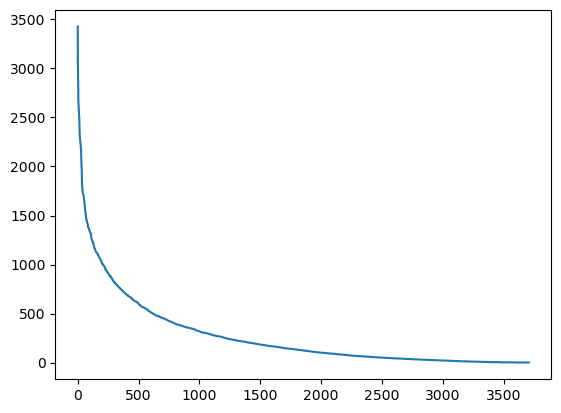

In [140]:
df_ratings.groupby('MovieID')['Rating'].count().sort_values(ascending=False).reset_index(drop=True).plot()

<AxesSubplot:>

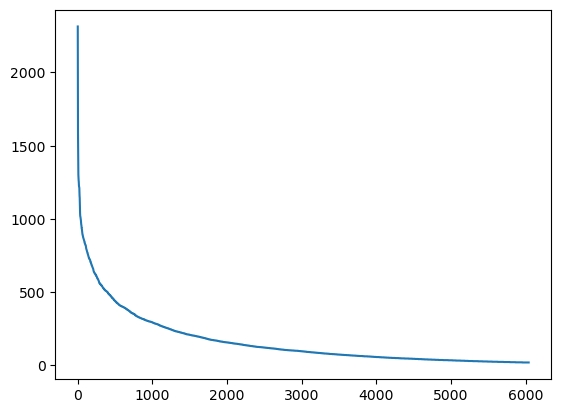

In [141]:
df_ratings.groupby('UserID')['Rating'].count().sort_values(ascending=False).reset_index(drop=True).plot()

In [143]:
df_movies_x = df_movies.merge(df_ratings.groupby('MovieID')['Rating'].count().reset_index(),on='MovieID')

In [144]:
df_movies_1500 = df_movies_x.loc[sorted(df_movies_x['Rating'].sort_values(ascending=False)[:1500].index)]

In [162]:
# df_users_x.drop(columns=['Rating_x'],inplace=True)
df_users_x.rename(columns={'Rating_y':'Rating'},inplace=True)

In [157]:
df_users_x = df_users.merge(df_ratings.groupby('UserID')['Rating'].count().reset_index(),on='UserID')

In [163]:
df_users_1500 = df_users_x.loc[sorted(df_users_x['Rating'].sort_values(ascending=False)[:1500].index)]

In [166]:
df_movies_1500.shape,df_users_1500.shape

((1500, 23), (1500, 8))

In [174]:
df_ratings_1500=df_ratings.merge(df_users[['UserID']],on='UserID').merge(df_movies[['MovieID','Title']],on='MovieID')

In [175]:
df_ratings_1500.head()

,UserID,MovieID,Rating,Timestamp,datetime,year,hour,Day of Week,Age Categories,Title
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,22,Sunday,Under 18,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,2000-12-31 21:33:33,2000,21,Sunday,56+,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,2000-12-30 23:49:39,2000,23,Saturday,25-34,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,2000-12-30 18:01:19,2000,18,Saturday,25-34,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,2000-12-30 06:41:11,2000,6,Saturday,50-55,One Flew Over the Cuckoo's Nest (1975)


In [176]:
matrix = df_ratings_1500.pivot(index='UserID', columns='Title', values='Rating')

In [177]:
matrix

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,3.0,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
round(matrix.isna().sum().sum()/matrix.notna().sum().sum())  # sparse, for every value there are 21 Nan values

21

In [190]:
matrix.shape

(6040, 3706)

In [257]:
def fetch_items_from_user_user_matrix(matrix,similarity_matrix,picked_userid,no_similar_users=25,user_similarity_threshold=0.3, top_n_movies=10):
    user_similarity_corr = similarity_matrix.copy().drop(index=picked_userid)
    
    # Get top n similar users
    similar_users = user_similarity_corr[user_similarity_corr[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:no_similar_users]
   
    # Movies that the target user has watched
    picked_userid_watched = matrix_train[matrix_train.index == picked_userid].dropna(axis=1, how='all')
    
    # Movies that similar users watched. Remove movies that none of the similar users have watched
    similar_user_movies = matrix_train[matrix_train.index.isin(similar_users.index)].dropna(axis=1, how='all')   
    similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
    
    # A dictionary to store item scores
    item_score = {}

    # Loop through items
    for i in similar_user_movies.columns:
      # Get the ratings for movie i
      movie_rating = similar_user_movies[i]
      # Create a variable to store the score
      total = 0
      # Create a variable to store the number of scores
      count = 0
      # Loop through similar users
      for u in similar_users.index:
        # If the movie has rating
        if pd.isna(movie_rating[u]) == False:
          # Score is the sum of user similarity score multiply by the movie rating
          score = similar_users[u] * movie_rating[u]
          # Add the score to the total score for the movie so far
          total += score
          # Add 1 to the count
          count +=1
      # Get the average score for the item
      item_score[i] = total / count

    # Convert dictionary to pandas dataframe
    item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

    # Sort the movies by score
    ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

    return ranked_item_score.head(top_n_movies)
    

In [258]:
def fetch_items_from_item_item_matrix(matrix,item_similarity, picked_userid, picked_movie,n=10):
    picked_userid_watched = pd.DataFrame(matrix.T[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={picked_userid:'rating'})
    # Similarity score of the movie American Pie with all the other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})

    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                                right=picked_movie_similarity_score, 
                                                on='Title', 
                                                how='inner')\
                                         .sort_values('similarity_score', ascending=False)[:n]
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

    print(f"The predicted rating for '{picked_movie}' by user '{picked_userid}' is '{predicted_rating}'" )

In [193]:
matrix_train,matrix_test = train_test_split(matrix,test_size=.15,random_state=42)

In [194]:
matrix_train.shape,matrix_test.shape

((5134, 3706), (906, 3706))

In [197]:
matrix_train.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### User similarity using User-User Pearson correlation matrix

In [212]:
user_similarity_corr = matrix_train.T.corr()

In [223]:
user_similarity_corr.head()

UserID,1043,5783,3169,5542,4261,4499,2689,556,3009,978,...,4427,5335,467,5735,3093,3773,5192,5227,5391,861
UserID,,,,,,,,,,,,,,,,,,,,,
1043,1.000000e+00,NaN,NaN,0.5,-4.299875e-17,NaN,NaN,0.612372,1.000000,NaN,...,NaN,0.666667,0.548608,NaN,-2.187181e-17,4.210162e-03,NaN,0.500000,NaN,1.000000e+00
3169,NaN,NaN,1.000000,NaN,3.880994e-01,0.665160,-0.060193,0.050489,NaN,NaN,...,NaN,0.343616,NaN,NaN,-3.333333e-01,5.264073e-01,0.500000,0.539342,-0.522233,9.221389e-02
5542,5.000000e-01,NaN,NaN,1.0,NaN,-0.200000,-0.612372,0.288675,NaN,NaN,...,NaN,1.000000,NaN,NaN,7.814647e-01,-2.452281e-02,NaN,NaN,NaN,NaN
4261,-4.299875e-17,NaN,0.388099,NaN,1.000000e+00,0.541871,0.075378,0.508187,0.378188,0.527046,...,0.088297,-0.080965,0.166957,-0.103299,-3.553252e-01,5.941012e-02,0.800095,0.088249,0.443785,5.689141e-17
4499,NaN,0.762493,0.665160,-0.2,5.418706e-01,1.000000,0.059536,0.477210,1.000000,0.286147,...,0.612372,0.021079,0.177332,0.962250,1.430879e-01,-1.317123e-16,1.000000,-0.191486,NaN,-8.017837e-01


In [226]:
fetch_items_from_user_user_matrix(matrix_train,user_similarity_corr,5542)

,movie,movie_score
574,"King and I, The (1956)",5.0
978,Steel Magnolias (1989),5.0
228,Conan the Barbarian (1982),5.0
233,"Conversation, The (1974)",5.0
235,Cookie's Fortune (1999),5.0
244,Creepshow (1982),5.0
245,Creepshow 2 (1987),5.0
252,Crumb (1994),5.0
253,"Crush, The (1993)",5.0
271,"Dead Zone, The (1983)",5.0


### User similarity using User-User Cosine similarity matrix

In [227]:
user_similarity_cosine = cosine_similarity(matrix_train.fillna(0))

In [232]:
user_similarity_cosine = pd.DataFrame(data=user_similarity_cosine,columns=matrix_train.index,index=matrix_train.index)

In [233]:
fetch_items_from_user_user_matrix(matrix_train,user_similarity_cosine,5542)

,movie,movie_score
439,"Grand Day Out, A (1992)",1.720979
700,My Best Fiend (Mein liebster Feind) (1999),1.720979
753,Once Upon a Time... When We Were Colored (1995),1.668122
577,Kundun (1997),1.668122
102,Beautiful Thing (1996),1.668122
877,Romeo and Juliet (1968),1.664460
151,Bound (1996),1.635513
383,Frances (1982),1.635513
220,City of Angels (1998),1.635513
424,Gods and Monsters (1998),1.635513


### Item similarity using Item-Item Pearson correlation matrix

In [234]:
item_similarity_corr = matrix_train.corr()

In [235]:
item_similarity_corr.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000e+00,5.222330e-01,NaN,9.410021e-17,0.422577,NaN,-0.455383,0.682276,0.184521,0.221655,...,1.000000,-0.276956,NaN,0.000000,NaN,-1.000000,0.108465,NaN,9.449112e-01,-0.500000
'Night Mother (1986),5.222330e-01,1.000000e+00,-6.966594e-17,2.174729e-01,0.235483,NaN,0.260513,0.246671,-0.150908,0.177509,...,0.774597,-0.314347,1.000000,-0.045929,NaN,-0.492518,0.082580,NaN,NaN,0.069171
'Til There Was You (1997),NaN,-6.966594e-17,1.000000e+00,8.503904e-01,0.719676,NaN,0.202885,0.331522,0.467771,0.272166,...,NaN,-0.016137,NaN,0.071734,NaN,NaN,0.186509,NaN,1.000000e+00,0.300123
"'burbs, The (1989)",9.410021e-17,2.174729e-01,8.503904e-01,1.000000e+00,0.179745,NaN,0.157364,0.089108,0.121649,0.052677,...,0.366215,0.317855,NaN,0.198618,NaN,0.080064,0.050885,NaN,1.570092e-16,0.106804
...And Justice for All (1979),4.225771e-01,2.354830e-01,7.196763e-01,1.797450e-01,1.000000,NaN,0.254492,0.125029,-0.122809,0.278694,...,-0.271746,0.141718,0.310087,0.409788,NaN,-0.320256,0.224818,NaN,NaN,-0.031633


In [259]:
picked_userid = 5542
picked_movie = 'American Pie (1999)'

In [260]:
fetch_items_from_item_item_matrix(matrix_train,item_similarity_corr, picked_userid, picked_movie)

The predicted rating for 'American Pie (1999)' by user '5542' is '4.629108'


### Item similarity using Item-Item Cosine similairty matrix

In [261]:
item_similarity_cosine = cosine_similarity(matrix_train.T.fillna(0))

In [264]:
item_similarity_cosine = pd.DataFrame(data=item_similarity_cosine,columns=matrix_train.columns,index=matrix_train.columns)

In [269]:
item_similarity_cosine.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.077175,0.040719,0.089714,0.066385,0.000000,0.058165,0.196912,0.182027,0.097357,...,0.042300,0.082450,0.000000,0.050043,0.0,0.047620,0.039719,0.000000,0.124753,0.029790
'Night Mother (1986),0.077175,1.000000,0.121769,0.108498,0.160112,0.000000,0.083533,0.151401,0.101508,0.120849,...,0.058039,0.092846,0.073855,0.142361,0.0,0.096086,0.081879,0.000000,0.000000,0.078074
'Til There Was You (1997),0.040719,0.121769,1.000000,0.099920,0.074803,0.085592,0.118682,0.123273,0.132588,0.071414,...,0.032978,0.072235,0.000000,0.065533,0.0,0.024569,0.073385,0.000000,0.050984,0.067479
"'burbs, The (1989)",0.089714,0.108498,0.099920,1.000000,0.146753,0.000000,0.184452,0.234000,0.175561,0.177412,...,0.118071,0.202451,0.024530,0.125917,0.0,0.062293,0.172281,0.000000,0.037032,0.112678
...And Justice for All (1979),0.066385,0.160112,0.074803,0.146753,1.000000,0.000000,0.077838,0.190840,0.116698,0.201539,...,0.093248,0.163126,0.079411,0.099579,0.0,0.087619,0.104458,0.098266,0.000000,0.106734


In [268]:
fetch_items_from_item_item_matrix(matrix_train,item_similarity_cosine, picked_userid, picked_movie)

The predicted rating for 'American Pie (1999)' by user '5542' is '4.633477'


In [312]:
[(i,col) for i,col in enumerate(matrix_train.columns) if 'Liar Liar' in col]

[(1919, 'Liar Liar (1997)')]

In [291]:
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(matrix_train.T.fillna(0))

In [313]:
distances, indices = knn.kneighbors([matrix_train.iloc[:,1919].fillna(0)])

In [314]:
distances

array([[ 0.        , 75.4122006 , 76.85050423, 77.55643107, 77.59510294]])

In [315]:
indices

array([[1919,  579, 1559,  503, 1039]], dtype=int64)

In [316]:
matrix_train.iloc[:,indices[0]].columns

Index(['Liar Liar (1997)', 'Cable Guy, The (1996)',
       'Home Alone 2: Lost in New York (1992)',
       'Brady Bunch Movie, The (1995)', 'Encino Man (1992)'],
      dtype='object', name='Title')

#### The nearest movie for "Actor's Revenge, An (Yukinojo Henge) (1963)" are : 
'Metisse (Café au Lait) (1993)',
'Billy's Holiday (1995)',
       'Back Stage (2000)',
       'Broken Vessels (1998)'

In [309]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code,Age Categories,Occupation Category,Rating
0,1,F,1,10,48067,Under 18,K-12 student,53
1,2,M,56,16,70072,56+,self-employed,129
2,3,M,25,15,55117,25-34,scientist,51
3,4,M,45,7,02460,45-49,executive/managerial,21
4,5,M,25,20,55455,25-34,writer,198


In [303]:
rated_users = df_users['UserID'].isin(df_ratings['UserID'])

In [308]:
df_users[rated_users].groupby('Age Categories')['UserID'].count()

Age Categories
18-24       1103
25-34       2096
35-44       1193
45-49        550
50-55        496
56+          380
Under 18     222
Name: UserID, dtype: int64

In [299]:
df_ratings.groupby('Age Categories')

,UserID,MovieID,Rating,Timestamp,datetime,year,hour,Day of Week,Age Categories
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,22,Sunday,Under 18
1,1,661,3,978302109,2000-12-31 22:35:09,2000,22,Sunday,Under 18
2,1,914,3,978301968,2000-12-31 22:32:48,2000,22,Sunday,Under 18
3,1,3408,4,978300275,2000-12-31 22:04:35,2000,22,Sunday,Under 18
4,1,2355,5,978824291,2001-01-06 23:38:11,2001,23,Saturday,Under 18
...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41,2000,2,Wednesday,25-34
1000205,6040,1094,5,956704887,2000-04-25 23:21:27,2000,23,Tuesday,25-34
1000206,6040,562,5,956704746,2000-04-25 23:19:06,2000,23,Tuesday,25-34
1000207,6040,1096,4,956715648,2000-04-26 02:20:48,2000,2,Wednesday,25-34
